In [10]:
#Campeonato Quantamental
#Pegando dados P/L
import requests
import pandas as pd
import io
import json
import re
import pandas as pd
from pandas_datareader import data, wb
import numpy as np


In [ ]:
headers = {
    'authority': 'www.oceans14.com.br',
    'accept': 'application/json, text/javascript, */*; q=0.01',
    'user-agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Mobile Safari/537.36',
    'x-requested-with': 'XMLHttpRequest',
    'sec-fetch-site': 'same-origin',
    'sec-fetch-mode': 'cors',
    'sec-fetch-dest': 'empty',
    # coloque aqui a url de qualquer canto que seja do site oceans14
    'referer': 'https://www.oceans14.com.br/acoes/itau-unibanco/itub/balanco-dividendos',
    'accept-language': 'pt-BR,pt;q=0.9,en-US;q=0.8,en;q=0.7,la;q=0.6',
    'cookie': 'ASP.NET_SessionId=jypd15qvl1yu3ypbgqzecxjj; uid=0EAB27F50DB06E1775959795C4949E2D; origem=https://l.facebook.com/; contadorViewsAcoes=3',
}

params = (
    ######IDENTIFICAR TICKER DA ACAO######
    ('papel', 'ITUB3'),
    ('periodo', '10a'),
)

response = requests.get('https://www.oceans14.com.br/rendaVariavel/respostaAjax/gHistoricoPl.aspx', headers=headers, params=params)
dframe = pd.json_normalize(response.json())
jason = response.text
normal = json.loads(jason)
datas = []
valores = []
for row in normal["rows"]:
    date = row['c'][0]['v']
    formatedDate = re.search(r"(?<=Date\()[^\):]+(?=:?\))", date).group(0)
    simpleData = formatedDate.replace(',', '-').replace(' ', '')
    separatedData = simpleData.split('-')
    correctDataList = ''
    for number in separatedData:
        if number != '0':
            correctDataList += ("%02d" % int(number)) + "-"
    correctDataList = correctDataList[:-1]
    datas.append(correctDataList)
    valores.append(row['c'][1]['v'])
frameDict = {
    "Date": datas,
    "valores": valores
}

In [42]:
dframe = pd.DataFrame(data=frameDict)
df = pd.DataFrame()
df['valores'] = dframe['valores']#.values.tolist()
valores = df['valores']
dframe.set_index('Date',inplace=True)
dframe

,valores
Date,
2010-06-14,11.11
2010-06-15,11.00
2010-06-16,10.72
2010-06-19,10.87
2010-06-20,10.99
...,...
2020-06-03,10.34
2020-06-06,10.68
2020-06-07,10.43


In [51]:
#tickers = ['ITUB3.SA'] #IDENTIFICAR TICKER DA ACAO######
start_date = '2010-06-11'
end_date = '2020-06-08'
df = data.DataReader('ITUB3.SA', 'yahoo', start_date, end_date) #digitar ticker
dframe['Preco'] = df['Close']
#df[df['Close', 'Preco_Lucro']]
tabela = df.loc[: , 'Close']

In [52]:
dframe

,valores,Preco
Date,,
2010-06-14,11.11,NaN
2010-06-15,11.00,NaN
2010-06-16,10.72,NaN
2010-06-19,10.87,NaN
2010-06-20,10.99,NaN
...,...,...
2020-06-03,10.34,NaN
2020-06-06,10.68,NaN
2020-06-07,10.43,NaN


In [53]:
import talib
import matplotlib.pyplot as plt
import sys

upperband, middleband, lowerband = talib.BBANDS(tabela['Preco_Lucro'], timeperiod=200, nbdevup=2, nbdevdn=2, matype=0)
tabela['upperband'] = upperband
tabela['middleband'] = middleband
tabela['lowerband'] = lowerband

KeyError: 'Preco_Lucro'

In [5]:
#Logico

def buy_sell(df): 
  compras = []
  vendas = []
  #tickers = 'AAPL' ######IDENTIFICAR TICKER DA ACAO######
  flag = 3
  #flag = 1 comprado
  #flag = 0 vendeu

  for i in range(len(df)):
    if tabela['Preco_Lucro'][i] < tabela['lowerband'][i]:   
      if flag != 1:
        compras.append(tabela['Preco_Lucro'][i])
        vendas.append(np.nan)
        flag = 1
      else:
        compras.append(np.nan)
        vendas.append(np.nan)

    elif (tabela['Preco_Lucro'][i] > tabela['upperband'][i]):
      if ((flag != 0) & (flag != 3)):
        compras.append(np.nan)
        vendas.append(tabela['Preco_Lucro'][i])
        flag = 0
      else:
        compras.append(np.nan)
        vendas.append(np.nan)

    else:
      compras.append(np.nan)
      vendas.append(np.nan)
        
  return (compras, vendas)

In [6]:
buy_sell = buy_sell(df)
df['compra'] = buy_sell[0]
df['venda'] = buy_sell[1]

KeyError: 'lowerband'

KeyError: 'upperband'

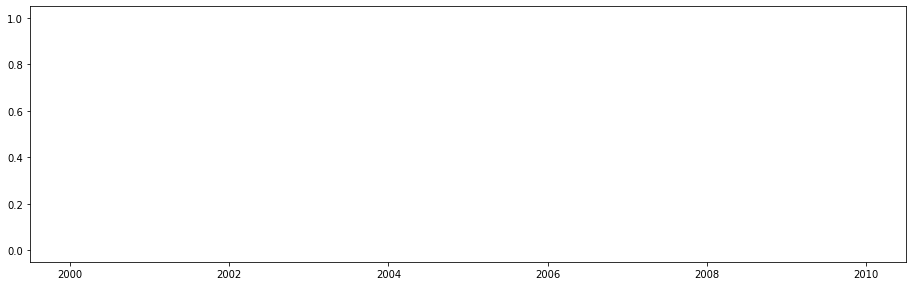

In [7]:
#tickers = 'AAPL' ######IDENTIFICAR TICKER DA ACAO######


plt.figure(figsize=(15.7,4.7))
plt.plot(tabela['Preco_Lucro'], label = 'Preço Lucro', alpha = 0.50)
plt.plot(tabela['upperband'], label = 'Banda Superior',alpha = 0.5) 
plt.plot(tabela['lowerband'], label = 'Banda Inferior',alpha = 0.5)
plt.scatter(df.index, df['compra'], label = 'Buy', marker="1",color = 'green')
plt.scatter(df.index, df['venda'], label = 'Sell',marker="v",color = 'red')
plt.xlabel('2010-10-18 - 2019-12-31', fontsize =15)
plt.title("Desvio PL", fontsize=15)
plt.legend(loc='upper left')


In [ ]:
#Calculo retorno da estrategia

